# Vehicle Price Prediction with Machine Learning

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Data preparation

### Upload Data

In [2]:
# load data

cars = pd.read_csv('/datasets/car_data.csv')

In [3]:
display(cars.sample(5))
display(cars.info())
display(cars.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
237850,12/03/2016 18:49,3300,sedan,2003,manual,102,a3,150000,3,petrol,audi,no,12/03/2016 00:00,0,78532,16/03/2016 00:46
210136,23/03/2016 18:49,2350,wagon,2001,auto,197,e_klasse,150000,0,gasoline,mercedes_benz,NaN,23/03/2016 00:00,0,1458,05/04/2016 23:45
212888,11/03/2016 17:53,599,sedan,1995,manual,75,colt,150000,6,petrol,mitsubishi,no,11/03/2016 00:00,0,45355,12/03/2016 08:15
20621,06/03/2016 21:06,3690,NaN,1995,NaN,0,other,150000,0,gasoline,fiat,NaN,06/03/2016 00:00,0,57299,30/03/2016 19:18
229541,21/03/2016 00:56,2700,NaN,2017,auto,0,fortwo,150000,2,petrol,smart,no,21/03/2016 00:00,0,77656,22/03/2016 12:16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Change Column Names

In [4]:
# change column names
cars = cars.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox',
       'Power': 'power', 'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand',
       'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

### Check for Duplicates

In [5]:
# check for duplicate data
cars.duplicated().sum()

262

In [6]:
# remove duplicates
cars = cars.drop_duplicates().reset_index(drop = True)

# check duplicates were removed
cars.duplicated().sum()

0

### Check for Missing Data

In [7]:
# check for missing values
cars.isnull().sum()

date_crawled              0
price                     0
vehicle_type          37484
registration_year         0
gearbox               19830
power                     0
model                 19701
mileage                   0
registration_month        0
fuel_type             32889
brand                     0
not_repaired          71145
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [8]:
# percentage of missing values

print("Missing value percentage in vehicle_type column: {:.2%}".format(cars['vehicle_type'].isnull().sum() / cars['vehicle_type'].count()))

print("Missing value percentage in gearbox column: {:.2%}".format(cars['gearbox'].isnull().sum() / cars['gearbox'].count()))

print("Missing value percentage in model column: {:.2%}".format(cars['model'].isnull().sum() / cars['model'].count()))

print("Missing value percentage in fuel_type column: {:.2%}".format(cars['fuel_type'].isnull().sum() / cars['fuel_type'].count()))

print("Missing value percentage in not_repaired column: {:.2%}".format(cars['not_repaired'].isnull().sum() / cars['not_repaired'].count()))

Missing value percentage in vehicle_type column: 11.84%
Missing value percentage in gearbox column: 5.93%
Missing value percentage in model column: 5.89%
Missing value percentage in fuel_type column: 10.24%
Missing value percentage in not_repaired column: 25.14%


In [9]:
# function to replace missing values
def replace_missing_value(unique_value_feature, col_to_replace):  
    """
    This function is used to replace a missing value in a column
    using possible unique value features for those missing values    
    """
    # get unique value of feature from this dataframe
    for value in cars[unique_value_feature].unique().tolist():
        # get specific value of features using possible value from column value to replace
        specific_value_cars = cars[cars[unique_value_feature] == value].dropna()[col_to_replace]    
        value_replacement_list = specific_value_cars.unique().tolist()
        # for the missing value, assign a random choice of the replacement value for that unknown value
        if value_replacement_list != []:
            cars.loc[(cars[unique_value_feature] == value) & (cars[col_to_replace] != cars[col_to_replace]), col_to_replace] = random.choice(value_replacement_list)
        else:
            cars.loc[(cars[unique_value_feature] == value) & (cars[col_to_replace] != cars[col_to_replace]), col_to_replace] = cars[col_to_replace].mode()

In [10]:
# replace missing values in model column
replace_missing_value('brand', 'model')

print("Missing value percentage in model column: {:.2%}".format(cars['model'].isnull().sum() / cars['model'].count()))

Missing value percentage in model column: 0.96%


In [11]:
# replace missing values in vehicle type
replace_missing_value('model', 'vehicle_type')

print("Missing value percentage in vehicle_type column: {:.2%}".format(cars['vehicle_type'].isnull().sum() / cars['vehicle_type'].count()))

Missing value percentage in vehicle_type column: 0.30%


In [12]:
replace_missing_value('model', 'gearbox')

print("Missing value percentage in gearbox column: {:.2%}".format(cars['gearbox'].isnull().sum() / cars['gearbox'].count()))

Missing value percentage in gearbox column: 0.31%


In [13]:
replace_missing_value('model', 'fuel_type')

print("Missing value percentage in fuel_type column: {:.2%}".format(cars['fuel_type'].isnull().sum() / cars['fuel_type'].count()))

Missing value percentage in fuel_type column: 0.31%


In [14]:
cars['not_repaired'].fillna('unknown', inplace=True)

print("Missing value percentage in not_repaired column: {:.2%}".format(cars['not_repaired'].isnull().sum() / cars['not_repaired'].count()))

Missing value percentage in not_repaired column: 0.00%


In [15]:
cars.isnull().sum()

date_crawled             0
price                    0
vehicle_type          1042
registration_year        0
gearbox               1104
power                    0
model                 3373
mileage                  0
registration_month       0
fuel_type             1104
brand                    0
not_repaired             0
date_created             0
number_of_pictures       0
postal_code              0
last_seen                0
dtype: int64

In [16]:
cars.dropna(inplace = True)

cars.isnull().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Change Datatypes

In [17]:
# change data types to datetime
cars['date_crawled'] = pd.to_datetime(cars['date_crawled'])
cars['date_created'] = pd.to_datetime(cars['date_created'])
cars['last_seen'] = pd.to_datetime(cars['last_seen'])

In [18]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350733 entries, 0 to 354106
Data columns (total 16 columns):
date_crawled          350733 non-null datetime64[ns]
price                 350733 non-null int64
vehicle_type          350733 non-null object
registration_year     350733 non-null int64
gearbox               350733 non-null object
power                 350733 non-null int64
model                 350733 non-null object
mileage               350733 non-null int64
registration_month    350733 non-null int64
fuel_type             350733 non-null object
brand                 350733 non-null object
not_repaired          350733 non-null object
date_created          350733 non-null datetime64[ns]
number_of_pictures    350733 non-null int64
postal_code           350733 non-null int64
last_seen             350733 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 45.5+ MB


### Check for Outliers

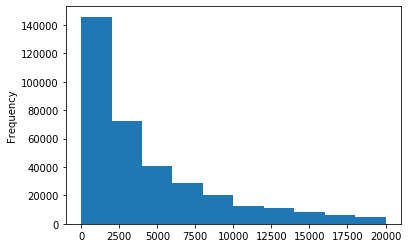

In [19]:
cars['price'].plot(kind='hist')

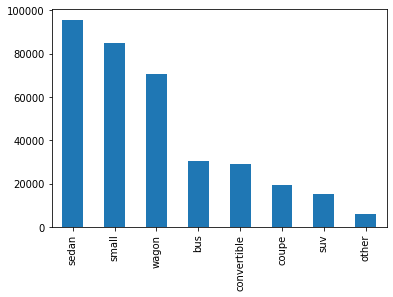

In [20]:
cars['vehicle_type'].value_counts().plot(kind = 'bar')

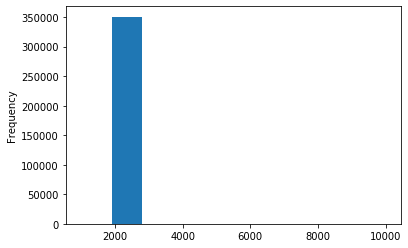

In [21]:
cars['registration_year'].plot(kind='hist')

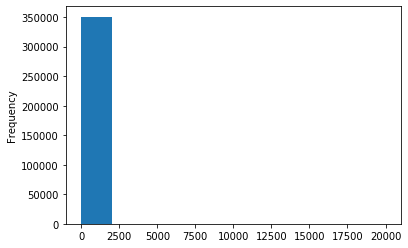

In [22]:
cars['power'].plot(kind = 'hist')

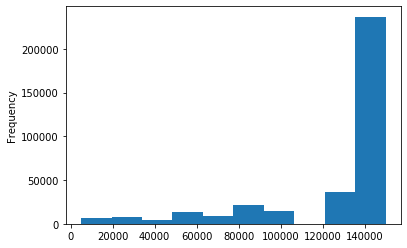

In [23]:
cars['mileage'].plot(kind='hist')

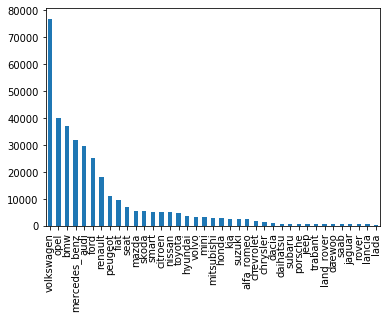

In [24]:
cars['brand'].value_counts().plot(kind = 'bar')

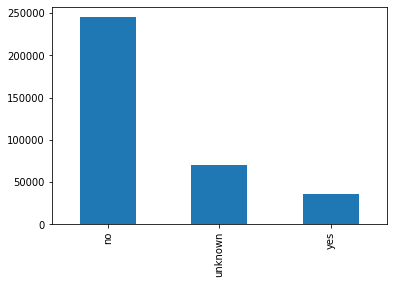

In [25]:
cars['not_repaired'].value_counts().plot(kind = 'bar')

In [26]:
# filter out outliers
cars_filtered = cars[(cars['registration_year'] <= 2016) & (cars['power'] <= 2500)]

In [27]:
display(cars_filtered.describe())

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,336279.000000,336279.000000,336279.00000,336279.000000,336279.000000,336279.0,336279.000000
mean,4464.186527,2002.449074,108.67841,128425.607903,5.767800,0.0,50634.424389
std,4535.534394,12.486273,72.49573,37500.674009,3.704346,0.0,25788.456948
min,0.000000,1000.000000,0.00000,5000.000000,0.000000,0.0,1067.000000
25%,1100.000000,1999.000000,69.00000,125000.000000,3.000000,0.0,30179.000000
50%,2799.000000,2003.000000,105.00000,150000.000000,6.000000,0.0,49504.000000
75%,6500.000000,2007.000000,143.00000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,2016.000000,2461.00000,150000.000000,12.000000,0.0,99998.000000


**Conclusion**

Our data consists of 16 columns and 354,369 entries. There are 262 duplicate rows. We removed the duplicated rows. There are 5 columns with missing values: vehicle_type, gearbox, model, fuel_type, and not_repaired. We replaced missing values in the columns vehicle_type, gearbox, model, and fuel_type by replacing missing values in a column using possible unique value features for those missing values. We replaced missing values in not_repaired with the value unknown. We removed the remaining missing values because they were less than 1% of our data. We changed the columns date_crawled, date_created, and last_seen to datatype datetime. We notices some cars have a registration_year after the current year. This is an anomaly in the data. We filtered out all data with a registration_year after 2016. We found outliers about 2500 in the column power, this data was removed. The data is now ready for training.

## Model training

In [28]:
#drop unimportant features

cars_df = cars_filtered.drop(['date_crawled', 'registration_year', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336279 entries, 0 to 354106
Data columns (total 9 columns):
price           336279 non-null int64
vehicle_type    336279 non-null object
gearbox         336279 non-null object
power           336279 non-null int64
model           336279 non-null object
mileage         336279 non-null int64
fuel_type       336279 non-null object
brand           336279 non-null object
not_repaired    336279 non-null object
dtypes: int64(3), object(6)
memory usage: 25.7+ MB


### Linear Regression 

In [29]:
#one-hot Encoding for categorical features
cars_ohe = pd.get_dummies(cars_df, drop_first = True)

cars_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336279 entries, 0 to 354106
Columns: 306 entries, price to not_repaired_yes
dtypes: int64(3), uint8(303)
memory usage: 107.4 MB


In [30]:

lr_target = cars_ohe['price']
lr_features = cars_ohe.drop('price', axis=1)

lr_features_train, lr_features_test, lr_target_train, lr_target_test = train_test_split(lr_features, lr_target, test_size=0.25, random_state=12345)

display(lr_features_train.shape)
display(lr_features_test.shape)

numerical = [column for column in lr_features_train.columns if lr_features_train[column].dtype in ['int64', 'int32']]

scaler = StandardScaler()
scaler.fit(lr_features_train[numerical])

lr_features_train[numerical] = scaler.transform(lr_features_train[numerical])
lr_features_test[numerical] = scaler.transform(lr_features_test[numerical])

lr_features_train.sample(5)

(252209, 305)

(84070, 305)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

,power,mileage,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
174905,-0.743679,0.575104,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
309773,0.099475,0.575104,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
142945,-1.503899,-0.757889,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
92111,-0.163146,0.575104,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
261144,-0.370479,0.575104,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
%%time

lr_model = LinearRegression(random_state=12345)
lr_model.fit(lr_features_train, lr_target_train)
lr_predict = lr_model.predict(lr_features_test)
lr_rmse = np.sqrt(mean_squared_error(lr_target_test, lr_predict))

print('RMSE Linear Regression Model: {:.2f}'.format(lr_rmse))

### Random Forest Regressor

In [32]:
rf_target = cars_df['price']
rf_features = cars_df.drop('price', axis=1)

# split data
rf_features_train, rf_features_test, rf_target_train, rf_target_test = train_test_split(rf_features, rf_target, test_size=0.25, random_state=12345)

display(rf_features_train.shape)
display(rf_features_test.shape)

categorical_cols = [cname for cname in rf_features.columns if rf_features[cname].dtype == 'object']

encoder = OrdinalEncoder()

rf_features_train[categorical_cols] = encoder.fit_transform(rf_features_train[categorical_cols])
rf_features_test[categorical_cols] = encoder.transform(rf_features_test[categorical_cols])

(252209, 8)

(84070, 8)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

In [33]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {
    "n_estimators" : [50, 100],
    "max_depth" : [None, 5, 10],
    "min_samples_leaf" : [2, 4]
}
# define the model 
regressor = RandomForestRegressor(random_state = 12345)
# define the grid search
grid_search_rf = GridSearchCV(estimator = regressor, param_grid = grid, scoring="neg_mean_squared_error", cv=5)
# execute search
grid_search_rf.fit(rf_features_train, rf_target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_rf.best_params_))

The best hyperparameters are: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
CPU times: user 15min 10s, sys: 2.64 s, total: 15min 12s
Wall time: 15min 19s


In [34]:
%%time

rf_model = RandomForestRegressor(**grid_search_rf.best_params_)
rf_model.fit(rf_features_train, rf_target_train)
rf_predict = rf_model.predict(rf_features_test)
rf_rmse = np.sqrt(mean_squared_error(rf_target_test, rf_predict))

print('RMSE Random Forest Regression Model: {:.2f}'.format(rf_rmse))

RMSE Random Forest Regression Model: 2199.54
CPU times: user 39.4 s, sys: 244 ms, total: 39.7 s
Wall time: 40.1 s


### LightGBM

In [ ]:
lgbm_features = rf_features.copy()
lgbm_target = rf_target.copy()

for c in lgbm_features.columns:
    col_type = lgbm_features[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        lgbm_features[c] = lgbm_features[c].astype('category')

lgbm_features_train, lgbm_features_test, lgbm_target_train, lgbm_target_test = train_test_split(lgbm_features, lgbm_target, test_size=0.25, random_state=12345)

display(lgbm_features_train.shape)
display(lgbm_features_test.shape)

In [ ]:
%%time
# hyperparameter optimization for LightGBM regression

# define hyperparameters to tune
lgbm_grid = {'learning_rate': [ 0.01, 0.1],
             'n_estimators': [50, 100],
             'num_leaves': [5, 10]
            }
# define the model 
lgbm_regr = LGBMRegressor(random_state = 12345)

# define the grid search
grid_search_lgbm = GridSearchCV(
    estimator = lgbm_regr, 
    param_grid = lgbm_grid, 
    scoring = "neg_mean_squared_error", 
    cv = 3, 
    n_jobs = 1
)
# execute search
grid_search_lgbm.fit(lgbm_features_train, lgbm_target_train, categorical_feature = 'auto', feature_name = 'auto')
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_lgbm.best_params_))

In [ ]:
%%time

lgbm_model = LGBMRegressor(**grid_search_lgbm.best_params_)
lgbm_model.fit(lgbm_features_train, lgbm_target_train)
lgbm_predict = lgbm_model.predict(lgbm_features_test)
lgbm_rmse = np.sqrt(mean_squared_error(lgbm_target_test, lgbm_predict))

print('RMSE LightGBM Regression Model: {:.2f}'.format(lgbm_rmse))

### CatBoost Regressor

In [38]:
cb_features = rf_features.copy()
cb_target = rf_target.copy()

cb_features_train, cb_features_test, cb_target_train, cb_target_test = train_test_split(cb_features, cb_target, test_size=0.25, random_state=12345)

cat_features = [
    'vehicle_type', 
    'gearbox', 
    'model', 
    'fuel_type', 
    'brand', 
    'not_repaired'
]

In [39]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {'learning_rate': [0.01, 0.1],
        'depth': [5, 10],
        'l2_leaf_reg': [1, 5]
       }
# define the model 
cb_regr = CatBoostRegressor(
    iterations=100,
    cat_features=cat_features,
    logging_level = 'Silent',
    loss_function='RMSE',
    early_stopping_rounds = 50,
    random_state = 12345)
# define the grid search
grid_search_cb = GridSearchCV(estimator = cb_regr, param_grid = grid, scoring="neg_mean_squared_error", cv=3)
# execute search
grid_search_cb.fit(cb_features_train, cb_target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_cb.best_params_))

The best hyperparameters are: {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CPU times: user 7min 10s, sys: 50.6 s, total: 8min 1s
Wall time: 8min 25s


In [40]:
%%time

cb_model = CatBoostRegressor(**grid_search_cb.best_params_)
cb_model.fit(cb_features_train, cb_target_train, eval_set=(cb_features_test,cb_target_test), cat_features=cat_features, verbose = False)
cb_predict = cb_model.predict(cb_features_test)
cb_rmse = np.sqrt(mean_squared_error(cb_target_test, cb_predict))

print('RMSE CatBoost Regression Model: {:.2f}'.format(cb_rmse))

RMSE CatBoost Regression Model: 2131.77
CPU times: user 15min 5s, sys: 1min 9s, total: 16min 14s
Wall time: 16min 17s


**Conclusion**

We trained different models with various hyperparameters. We compared multiple gradient boost models with a tree based algorithm and and linear regression approach, as well as the speed it took to train them. We used the linear regression model as a sanity check since it does not work well with hyperparameters. The other models we trained were random forest regressor, catboost regressor, and lightGBM regressor. The goal was to see which model, after hyperparmeter tuning, obtained the lowest RMSE score with the best time.

## Model analysis

In [41]:
# performance comparison of different models 
model = ['LinearRegressor', 'RandomForest', 'LightGBM', ' CatBoost']
rmse = [3093.29, 2206.24, 2473.80, 2129.41]
tune_time = ['0s', '15min 37s', '2min', '8min 15s']
pred_time = ['20s', '41s', '8s', '16min 4s']

models = pd.DataFrame(data = zip(model, rmse, tune_time, pred_time), columns = ['model', 'RMSE Score', 'Hyperparameter Tuning Time', 'Model Run Time'])

display(models)

,model,RMSE Score,Hyperparameter Tuning Time,Model Run Time
0,LinearRegressor,3093.29,0s,20s
1,RandomForest,2206.24,15min 37s,41s
2,LightGBM,2473.80,2min,8s
3,CatBoost,2129.41,8min 15s,16min 4s


**Conclusion**

From the model analysis we can see that the linear regressor model has the highest RMSE which is expected from our sanity check model. The model with the lowest RMSE score is the catboost model. The catboost model has the highest model run time. The lightGBM model has the lowest for both hyperparater tuning and model run time. 

## Conclusion

Our data contained 16 columns with 354,369 entries. To prepare our data for training, we removed duplicated rows. We found 5 columns with missing values. We filled in missing values by using unique value features for the missing values. We replaced missing values in the column not_repaired with 'unknown'. Any extra missing values were removed.We changed date features to the datatype datetime. We filtered out any cars with the registration_year after the year 2016 and with power above 2500. 

We compared gradient boost models with a tree based algorithm and a linear regression model to see which model worked best and had the fastest time. We trained our models with numerous hyperparmeters to find the best model with the lowest RMSE score. The linear regression model was used as our sanity check. The model obtained a RMSE score of 3093.29 and had a model runtime of 20s. We found that the catboost model has the lowest RMSE score of 2129.41 but is also the slowest of the models. The fastest model was the LightGBM model but it has the highest RMSE score of 2473.80. 

Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed